## This notebook is created for CS6741 - supervised learning

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sys
import os
#from ggplot import *
%matplotlib inline

### 1. data glance

first, take a fast data glance on Voice dataset.

In [2]:
data = pd.read_csv('voice.csv')
data.sample(5)

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
1751,0.183481,0.031576,0.181087,0.170815,0.198587,0.027772,3.224484,15.510407,0.815591,0.203101,...,0.183481,0.171749,0.044321,0.213333,0.773438,0.164062,6.882812,6.718750,0.128044,female
2496,0.212496,0.031747,0.213639,0.194373,0.230336,0.035963,1.915291,5.707926,0.828664,0.165729,...,0.212496,0.191128,0.049434,0.279070,1.044497,0.023438,8.390625,8.367188,0.061078,female
393,0.187114,0.068230,0.205589,0.130411,0.247781,0.117370,1.257246,3.977159,0.934562,0.545496,...,0.187114,0.111075,0.016967,0.216216,0.423958,0.007812,3.757812,3.750000,0.111638,male
2655,0.185724,0.027836,0.185222,0.170058,0.196596,0.026538,2.848187,12.584084,0.800458,0.146275,...,0.185724,0.170598,0.058465,0.271186,0.714527,0.187500,2.882812,2.695312,0.088199,female
990,0.174255,0.061938,0.190076,0.113790,0.219482,0.105693,1.455816,5.050654,0.937345,0.579929,...,0.174255,0.126664,0.049536,0.279070,0.894440,0.023438,4.968750,4.945312,0.167498,male


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3168 entries, 0 to 3167
Data columns (total 21 columns):
meanfreq    3168 non-null float64
sd          3168 non-null float64
median      3168 non-null float64
Q25         3168 non-null float64
Q75         3168 non-null float64
IQR         3168 non-null float64
skew        3168 non-null float64
kurt        3168 non-null float64
sp.ent      3168 non-null float64
sfm         3168 non-null float64
mode        3168 non-null float64
centroid    3168 non-null float64
meanfun     3168 non-null float64
minfun      3168 non-null float64
maxfun      3168 non-null float64
meandom     3168 non-null float64
mindom      3168 non-null float64
maxdom      3168 non-null float64
dfrange     3168 non-null float64
modindx     3168 non-null float64
label       3168 non-null object
dtypes: float64(20), object(1)
memory usage: 507.4+ KB


In [4]:
data['label_binary'] = data['label']=='male'
data = data.drop(columns=['label'])

(array([1584.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1584.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

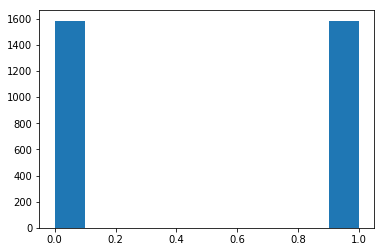

In [5]:
plt.hist(data['label_binary'])

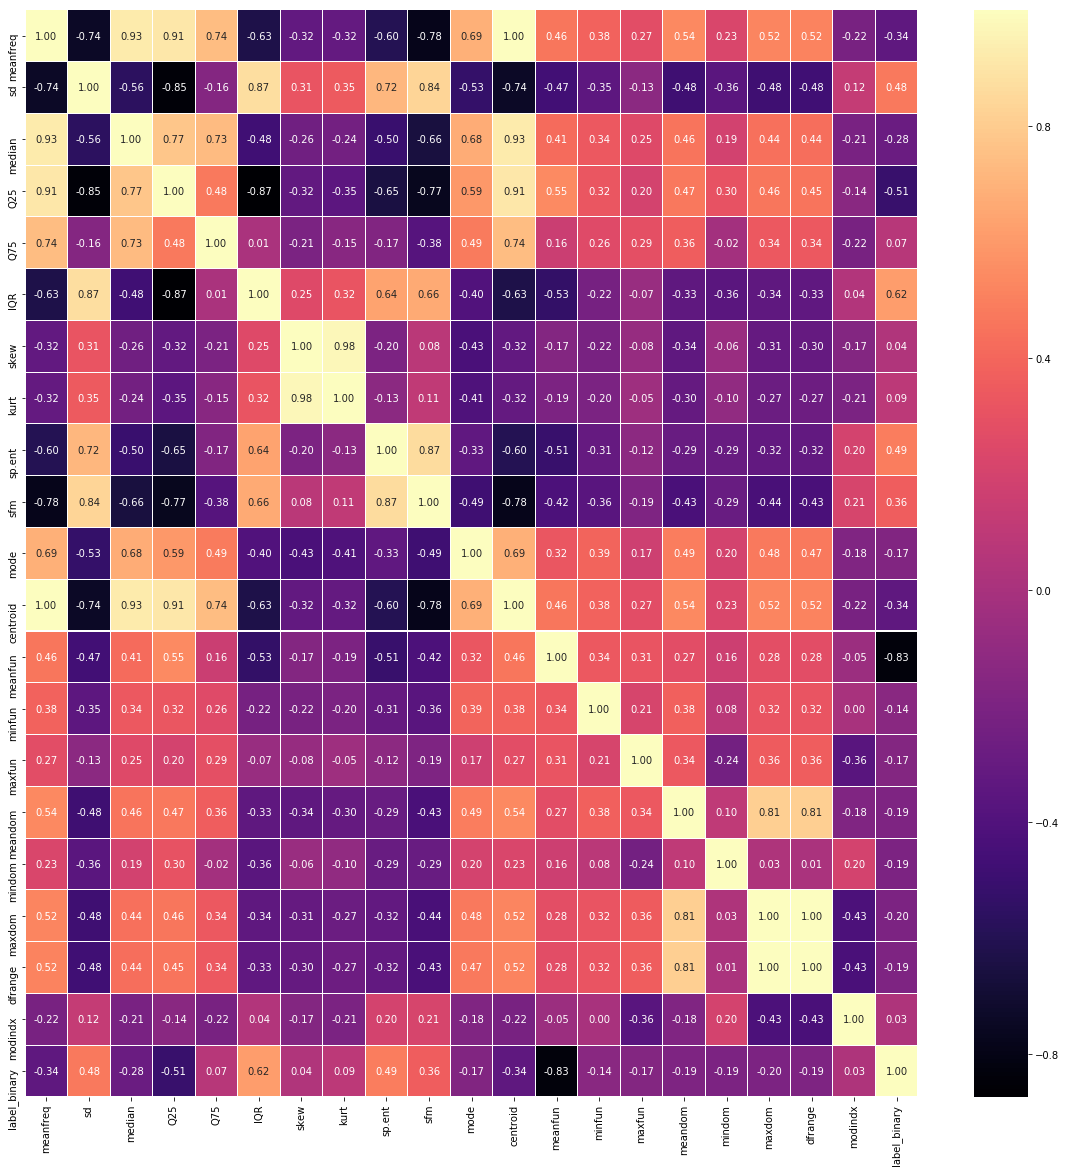

In [6]:
fig,ax = plt.subplots(figsize=(20, 20))
sns.heatmap(data.corr(), ax=ax, annot=True, linewidths=0.05, fmt= '.2f',cmap="magma")
plt.show()

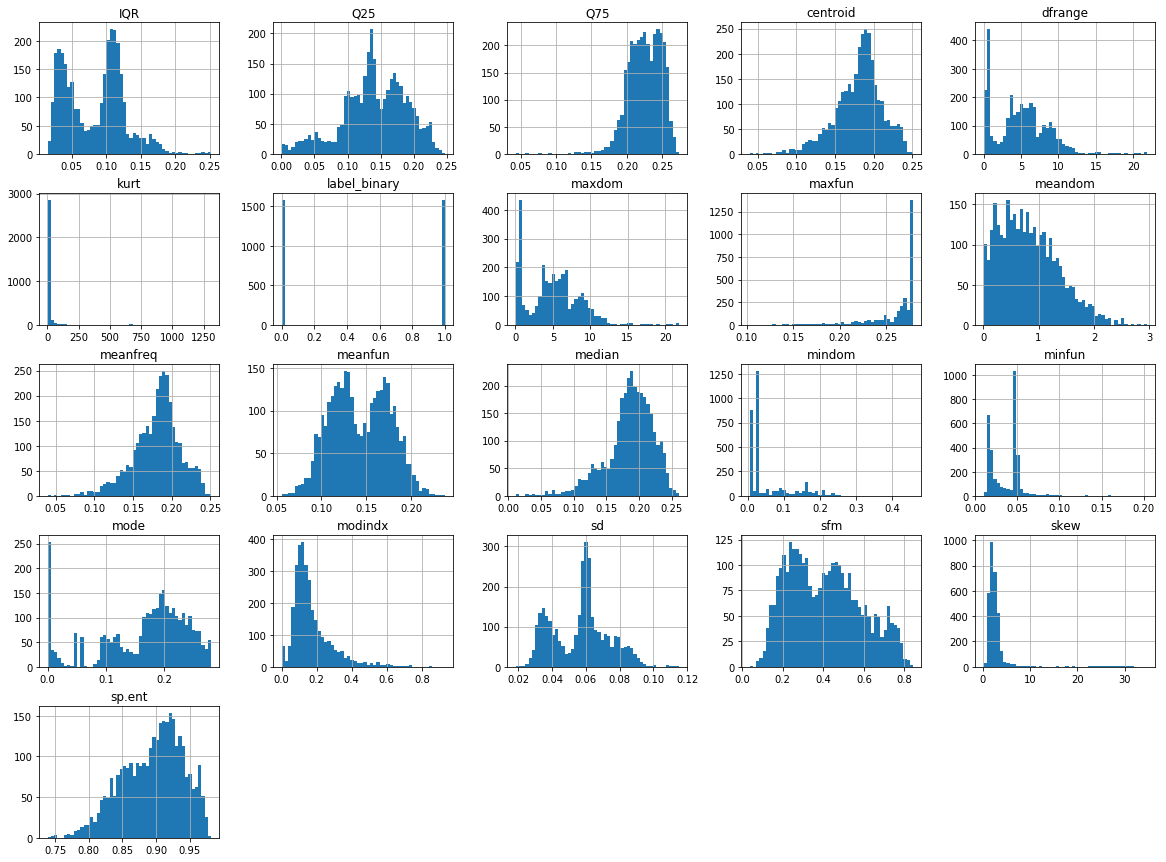

In [7]:
data.hist(bins=50, figsize=(20,15))
plt.show()

In [8]:
gender = data['label_binary'].values
features = data.drop(['label_binary'], axis=1).values
print ('Data is ready.')
print ('x shape', features.shape)
print ('y shape', gender.shape)

Data is ready.
('x shape', (3168, 20))
('y shape', (3168,))


### 2. clustering

no need to normalize here

In [9]:
from scipy.stats import mode
from scipy.optimize import linear_sum_assignment as lsa
from sklearn.decomposition import PCA, FastICA
from sklearn import random_projection
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, calinski_harabaz_score

In [10]:
def calc_cluster_F1(y_true, y_cluster, return_all=False):
    clusters = np.unique(y_cluster)
    
    TP, FP = 0., 0.
    for c in clusters:
        y_true_cluster = y_true[y_cluster == c]
        ys = np.unique(y_true_cluster)
        cnts = [np.sum(y_true_cluster == y) for y in ys]
        
        # True positive: assign similar data in a cluster
        for cnt in cnts:
            if cnt > 1:
                TP += np.sum([i for i in range(1, cnt)])
                
        # False positive: assign different data in a cluster
        for i in range(len(cnts)):
            for j in range(i+1, len(cnts)):
                FP += cnts[i] * cnts[j]
                
    FN = 0.
    labels = np.unique(y_true)
    for y in labels:
        y_cluster_true = y_cluster[y_true == y]
        ys = np.unique(y_cluster_true)
        cnts = [np.sum(y_cluster_true == y) for y in ys]
        
        # False negative: assign similar data in different clusters
        for i in range(len(cnts)):
            for j in range(i+1, len(cnts)):
                FN += cnts[i] * cnts[j]
        
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2*precision*recall / (precision+recall)
    if return_all:
        return f1, precision, recall
    else:
        return f1

In [11]:
features_vis = TSNE(n_components=2, n_iter=250).fit_transform(features)

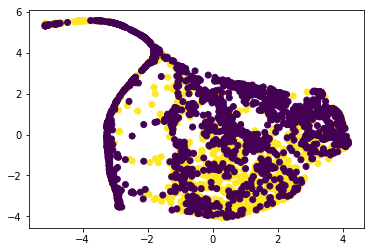

In [12]:
plt.scatter(features_vis[:,0], features_vis[:,1], c=gender)

#### 3.1 kmeans

Below I plot:

- SSD (Sum of square distances of samples to their closest cluster center) returned by score() method  *v.s.* k

- F1 (calculated by my self-implement function calc_cluster_F1())  *v.s.* k

- calinski_harabaz_score (see the report)  *v.s.* k

Use Elbow method, I choose $k^*=6$

In [13]:
Klist = [i for i in range(2, 11)]
score = [0. for _ in Klist]
shape = []
f1 = []
model = KMeans()

for i, k in enumerate(Klist):
    model.n_clusters = k
    model.fit(features)
    cluster = model.predict(features)
    
    # cluster score
    score[i] = -model.score(features, cluster)
    
    #
    s = calinski_harabaz_score(labels=cluster, X=features)
    shape.append(s)
    
    # 
    f1.append(calc_cluster_F1(gender, cluster))

Text(0.5,1,'f1 score v.s. k (kmeans on raw feature)')

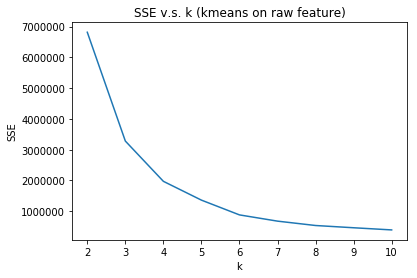

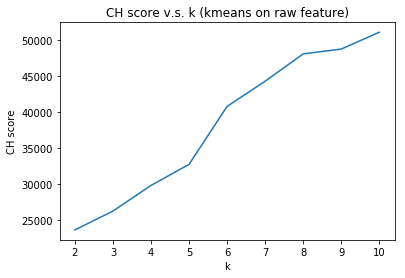

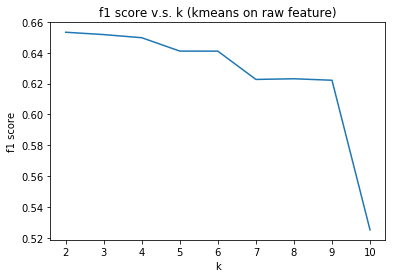

In [14]:
plt.figure()
plt.plot(Klist, score)
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('SSE v.s. k (kmeans on raw feature)')

plt.figure()
plt.plot(Klist, shape)
plt.xlabel('k')
plt.ylabel('CH score')
plt.title('CH score v.s. k (kmeans on raw feature)')

plt.figure()
plt.plot(Klist, f1)
plt.xlabel('k')
plt.ylabel('f1 score')
plt.title('f1 score v.s. k (kmeans on raw feature)')

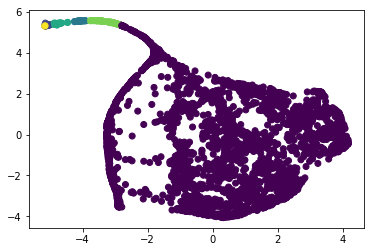

In [15]:
model = KMeans(n_clusters=6)
cluster = model.fit_predict(features)
plt.scatter(features_vis[:,0], features_vis[:,1], c=cluster)

#### 3.2 GMM

see the log_likelihood-k figure, it shows litter improvement when increasing $k$. while the other two figures show great decrasement, So I determine $k^*=3$ for GMM.

In [16]:
Klist = [i for i in range(2, 11)]
score = [0. for _ in Klist]
shape = []
f1 = []
model = GaussianMixture()

for i, k in enumerate(Klist):
    model.n_components = k
    model.fit(features)
    cluster = model.predict(features)
    
    # cluster score
    score[i] = model.score(features, cluster)
    
    #
    s = calinski_harabaz_score(labels=cluster, X=features)
    shape.append(s)
    
    # 
    f1.append(calc_cluster_F1(gender, cluster))

Text(0.5,1,'f1 score v.s. k (GMM on raw feature)')

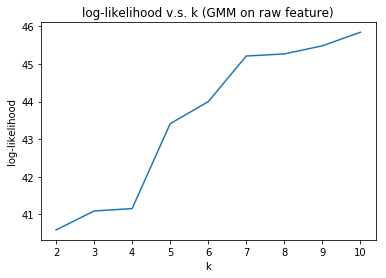

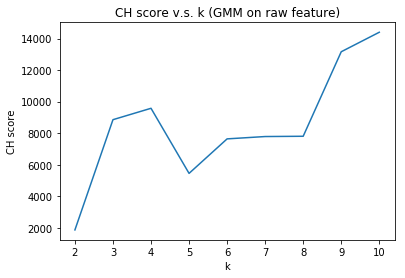

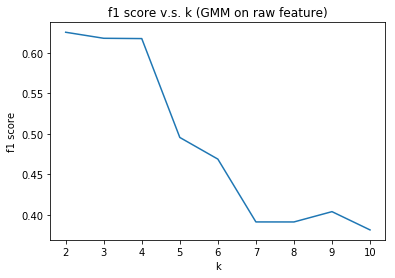

In [17]:
plt.figure()
plt.plot(Klist, score)
plt.xlabel('k')
plt.ylabel('log-likelihood')
plt.title('log-likelihood v.s. k (GMM on raw feature)')

plt.figure()
plt.plot(Klist, shape)
plt.xlabel('k')
plt.ylabel('CH score')
plt.title('CH score v.s. k (GMM on raw feature)')

plt.figure()
plt.plot(Klist, f1)
plt.xlabel('k')
plt.ylabel('f1 score')
plt.title('f1 score v.s. k (GMM on raw feature)')

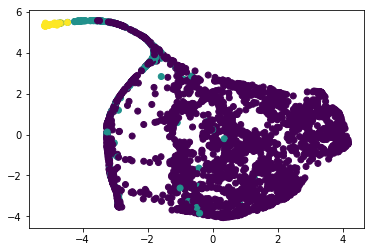

In [19]:
model = GaussianMixture(n_components=3)
cluster = model.fit_predict(features)
plt.scatter(features_vis[:,0], features_vis[:,1], c=cluster)

### 4. dimension reduction

#### 4.1 PCA and clustering on PCA

some conclusion:

- the first 5 principle components contains over 99% information of the original data, indicating PCA a good method for dimension reduction. I preserve the first 5 PCs as PCA feature.

- kmeans on PCA, $k^*=3$, with a no so high SSD, not so low CH score and f1 score

- GMM on PCA, $k^*=2$, 

Text(0,0.5,'ratio')

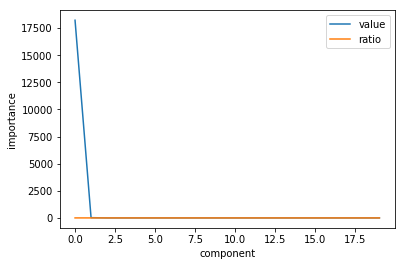

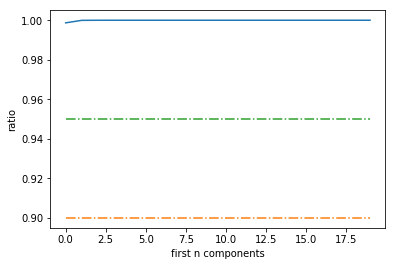

In [20]:
dimReduce = PCA()
dimReduce.fit(features)

plt.figure()
plt.plot(dimReduce.explained_variance_)
plt.plot(dimReduce.explained_variance_ratio_)
plt.xlabel('component')
plt.ylabel('importance')
plt.legend(['value', 'ratio'])

plt.figure()
plt.plot(np.cumsum(dimReduce.explained_variance_ratio_))
plt.plot([i for i in range(len(dimReduce.explained_variance_ratio_))],
        [0.9 for i in range(len(dimReduce.explained_variance_ratio_))], '-.')
plt.plot([i for i in range(len(dimReduce.explained_variance_ratio_))],
        [0.95 for i in range(len(dimReduce.explained_variance_ratio_))], '-.')
plt.xlabel('first n components')
plt.ylabel('ratio')

In [21]:
np.cumsum(dimReduce.explained_variance_ratio_)

array([0.99868143, 0.9999488 , 0.99999212, 0.99999722, 0.99999878,
       0.9999993 , 0.99999957, 0.99999975, 0.99999983, 0.99999989,
       0.99999994, 0.99999997, 0.99999998, 0.99999999, 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ])

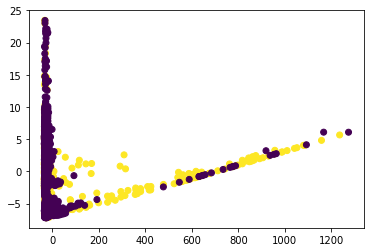

In [23]:
feature_PCA = dimReduce.transform(features)[:,:2]
plt.scatter(feature_PCA[:,0], feature_PCA[:,1], c=gender)

In [24]:
score = [0. for _ in Klist]
shape = []
f1 = []
model = KMeans()

for i, k in enumerate(Klist):
    model.n_clusters = k
    model.fit(feature_PCA)
    cluster = model.predict(feature_PCA)
    
    # cluster score
    score[i] = -model.score(feature_PCA, cluster)
    
    #
    s = calinski_harabaz_score(labels=cluster, X=feature_PCA)
    shape.append(s)
    
    # 
    f1.append(calc_cluster_F1(gender, cluster))

Text(0.5,1,'f1 score v.s. k (kmeans on top-2 principle components)')

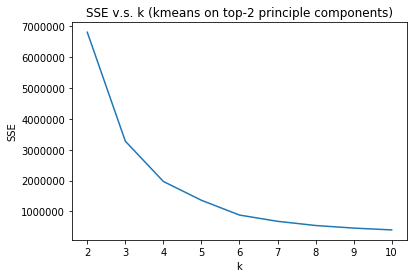

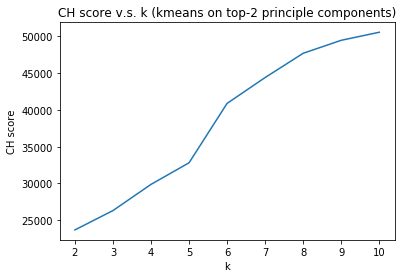

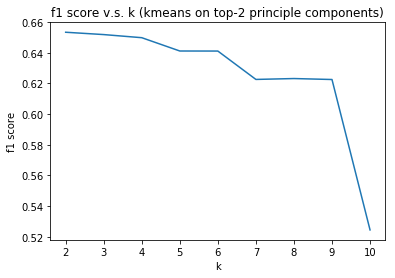

In [26]:
plt.figure()
plt.plot(Klist, score)
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('SSE v.s. k (kmeans on top-2 principle components)')

plt.figure()
plt.plot(Klist, shape)
plt.xlabel('k')
plt.ylabel('CH score')
plt.title('CH score v.s. k (kmeans on top-2 principle components)')

plt.figure()
plt.plot(Klist, f1)
plt.xlabel('k')
plt.ylabel('f1 score')
plt.title('f1 score v.s. k (kmeans on top-2 principle components)')


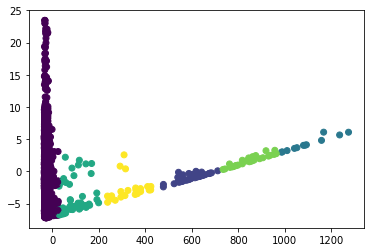

In [27]:
model.n_clusters = 6
model.fit(feature_PCA)
cluster = model.predict(feature_PCA)
plt.scatter(feature_PCA[:,0], feature_PCA[:,1], c=cluster)

In [28]:
score = [0. for _ in Klist]
shape = []
f1 = []
model = GaussianMixture()

for i, k in enumerate(Klist):
    model.n_components = k
    model.fit(feature_PCA)
    cluster = model.predict(feature_PCA)
    
    # cluster score
    score[i] = model.score(feature_PCA, cluster)
    
    #
    s = calinski_harabaz_score(labels=cluster, X=feature_PCA)
    shape.append(s)
    
    # 
    f1.append(calc_cluster_F1(gender, cluster))

Text(0.5,1,'f1 score v.s. k (GMM on top-2 principle components)')

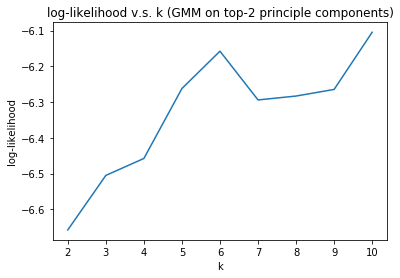

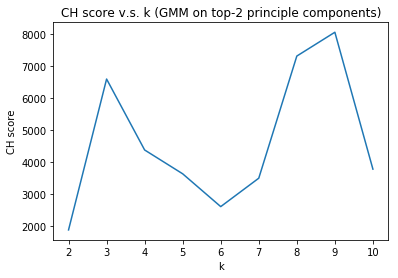

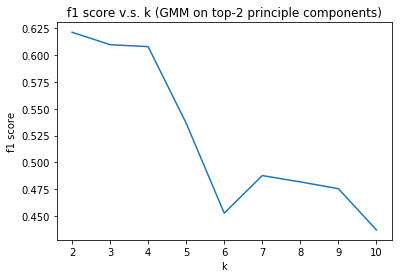

In [29]:
plt.figure()
plt.plot(Klist, score)
plt.xlabel('k')
plt.ylabel('log-likelihood')
plt.title('log-likelihood v.s. k (GMM on top-2 principle components)')

plt.figure()
plt.plot(Klist, shape)
plt.xlabel('k')
plt.ylabel('CH score')
plt.title('CH score v.s. k (GMM on top-2 principle components)')

plt.figure()
plt.plot(Klist, f1)
plt.xlabel('k')
plt.ylabel('f1 score')
plt.title('f1 score v.s. k (GMM on top-2 principle components)')

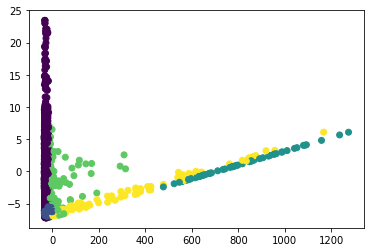

In [30]:
model.n_components = 5
model.fit(feature_PCA)
cluster = model.predict(feature_PCA)
plt.scatter(feature_PCA[:,0], feature_PCA[:,1], c=cluster)

#### 4.2 ICA and clustering on ICA

d:\python27\lib\site-packages\sklearn\decomposition\fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


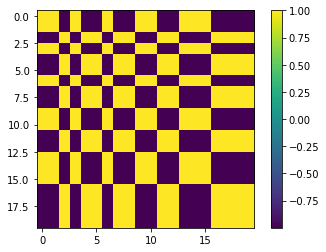

In [31]:
dimReduce = FastICA()
dimReduce.fit(features)

features_ICA = dimReduce.transform(features)

corr = np.corrcoef(features_ICA.T)
plt.imshow(corr)
plt.colorbar()

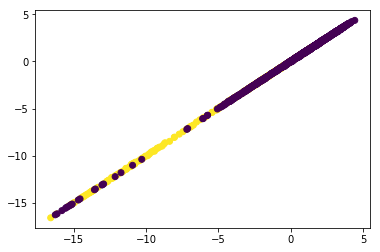

In [32]:
plt.scatter(features_ICA[:,0], features_ICA[:,1], c=gender)

In [33]:
score = [0. for _ in Klist]
shape = []
f1 = []
model = KMeans()

for i, k in enumerate(Klist):
    model.n_clusters = k
    model.fit(features_ICA)
    cluster = model.predict(features_ICA)
    
    # cluster score
    score[i] = -model.score(features_ICA, cluster)
    
    #
    s = calinski_harabaz_score(labels=cluster, X=features_ICA)
    shape.append(s)
    
    # 
    f1.append(calc_cluster_F1(gender, cluster))

Text(0.5,1,'f1 score v.s. k (kmeans on ICA features)')

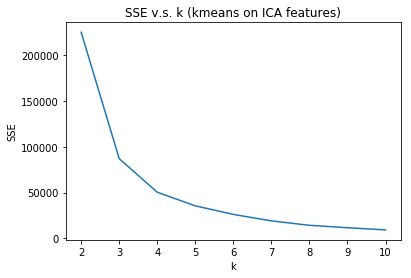

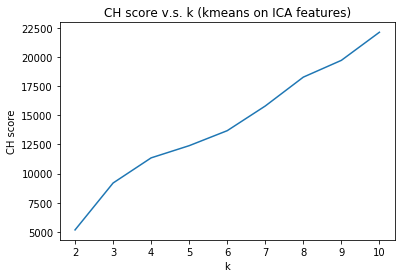

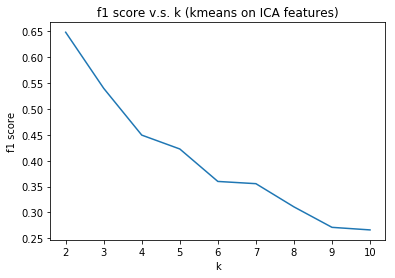

In [34]:
plt.figure()
plt.plot(Klist, score)
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('SSE v.s. k (kmeans on ICA features)')

plt.figure()
plt.plot(Klist, shape)
plt.xlabel('k')
plt.ylabel('CH score')
plt.title('CH score v.s. k (kmeans on ICA features)')

plt.figure()
plt.plot(Klist, f1)
plt.xlabel('k')
plt.ylabel('f1 score')
plt.title('f1 score v.s. k (kmeans on ICA features)')

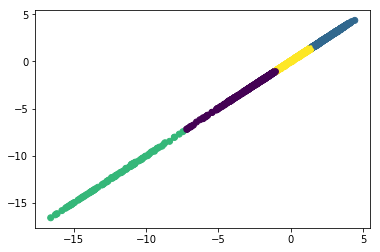

In [35]:
model = KMeans(n_clusters=4)
model.fit(features_ICA)
cluster = model.predict(features_ICA)
plt.scatter(features_ICA[:,0], features_ICA[:,1], c=cluster)

In [36]:
score = [0. for _ in Klist]
shape = []
f1 = []
model = GaussianMixture()

for i, k in enumerate(Klist):
    model.n_components = k
    model.fit(features_ICA)
    cluster = model.predict(features_ICA)
    
    # cluster score
    score[i] = model.score(features_ICA, cluster)
    
    #
    s = calinski_harabaz_score(labels=cluster, X=features_ICA)
    shape.append(s)
    
    # 
    f1.append(calc_cluster_F1(gender, cluster))

d:\python27\lib\site-packages\sklearn\mixture\base.py:273: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


Text(0.5,1,'f1 score v.s. k (GMM on ICA features)')

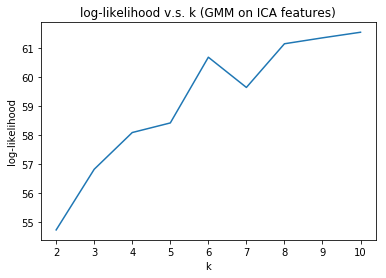

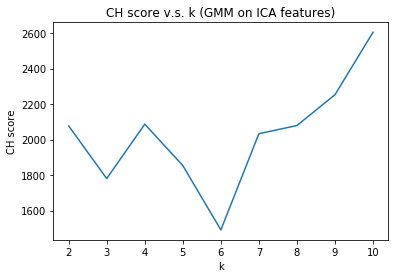

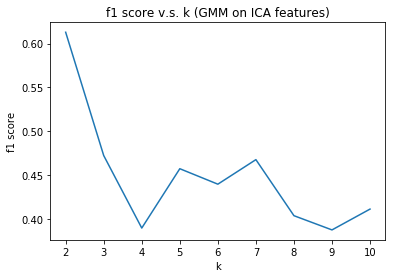

In [37]:
plt.figure()
plt.plot(Klist, score)
plt.xlabel('k')
plt.ylabel('log-likelihood')
plt.title('log-likelihood v.s. k (GMM on ICA features)')

plt.figure()
plt.plot(Klist, shape)
plt.xlabel('k')
plt.ylabel('CH score')
plt.title('CH score v.s. k (GMM on ICA features)')

plt.figure()
plt.plot(Klist, f1)
plt.xlabel('k')
plt.ylabel('f1 score')
plt.title('f1 score v.s. k (GMM on ICA features)')

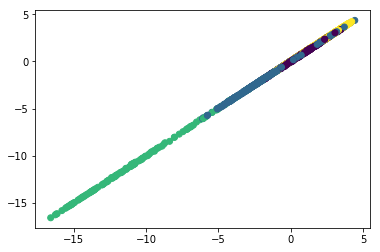

In [38]:
model = GaussianMixture(n_components = 4)
model.fit(features_ICA)
cluster = model.predict(features_ICA)
plt.scatter(features_ICA[:,0], features_ICA[:,1], c=cluster)

#### 4.3 random projection and clustering on random projection

In [39]:
dimReduce = random_projection.SparseRandomProjection(n_components=2)
dimReduce.fit(features)
features_rp = dimReduce.transform(features)

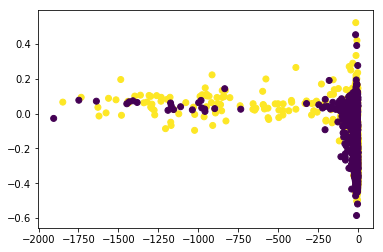

In [41]:
plt.scatter(features_rp[:,0], features_rp[:,1], c=gender)

In [42]:
score = [0. for _ in Klist]
shape = []
f1 = []
model = KMeans()

for i, k in enumerate(Klist):
    model.n_clusters = k
    model.fit(features_rp)
    cluster = model.predict(features_rp)
    
    # cluster score
    score[i] = -model.score(features_rp, cluster)
    
    #
    s = calinski_harabaz_score(labels=cluster, X=features_rp)
    shape.append(s)
    
    # 
    f1.append(calc_cluster_F1(gender, cluster))

Text(0.5,1,'f1 score v.s. k (kmeans on RP features)')

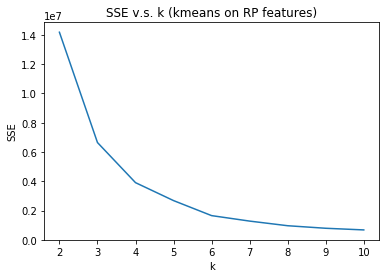

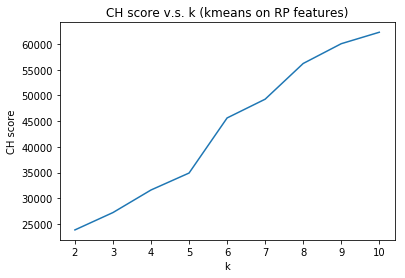

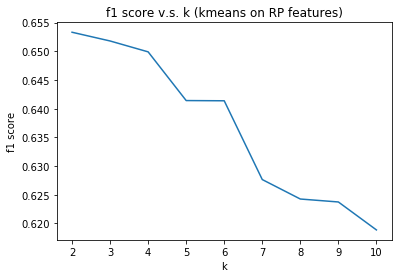

In [43]:
plt.figure()
plt.plot(Klist, score)
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('SSE v.s. k (kmeans on RP features)')

plt.figure()
plt.plot(Klist, shape)
plt.xlabel('k')
plt.ylabel('CH score')
plt.title('CH score v.s. k (kmeans on RP features)')

plt.figure()
plt.plot(Klist, f1)
plt.xlabel('k')
plt.ylabel('f1 score')
plt.title('f1 score v.s. k (kmeans on RP features)')

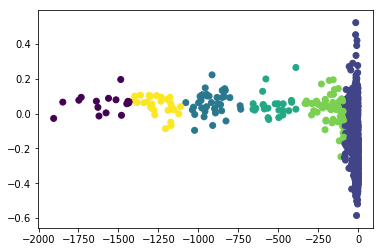

In [44]:
model = KMeans(n_clusters=6)
model.fit(features_rp)
cluster = model.predict(features_rp)
plt.scatter(features_rp[:,0], features_rp[:,1], c=cluster)

In [45]:
score = [0. for _ in Klist]
shape = []
f1 = []
model = GaussianMixture()

for i, k in enumerate(Klist):
    model.n_components = k
    model.fit(features_rp)
    cluster = model.predict(features_rp)
    
    # cluster score
    score[i] = model.score(features_rp, cluster)
    
    #
    s = calinski_harabaz_score(labels=cluster, X=features_rp)
    shape.append(s)
    
    # 
    f1.append(calc_cluster_F1(gender, cluster))

Text(0.5,1,'f1 score v.s. k (GMM on RP features)')

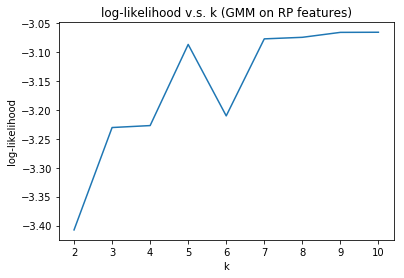

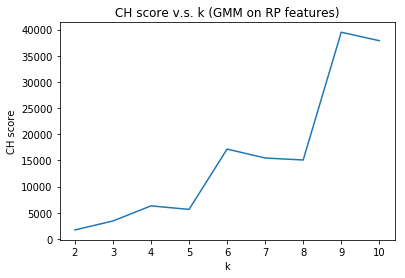

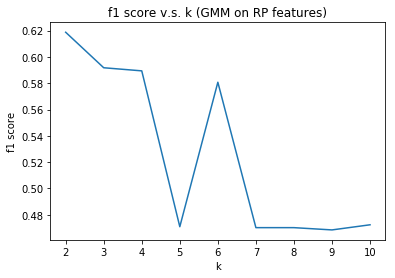

In [46]:
plt.figure()
plt.plot(Klist, score)
plt.xlabel('k')
plt.ylabel('log-likelihood')
plt.title('log-likelihood v.s. k (GMM on RP features)')

plt.figure()
plt.plot(Klist, shape)
plt.xlabel('k')
plt.ylabel('CH score')
plt.title('CH score v.s. k (GMM on RP features)')

plt.figure()
plt.plot(Klist, f1)
plt.xlabel('k')
plt.ylabel('f1 score')
plt.title('f1 score v.s. k (GMM on RP features)')

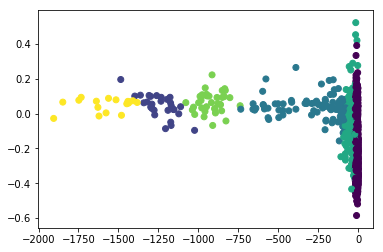

In [47]:
model = GaussianMixture(n_components = 6)
model.fit(features_rp)
cluster = model.predict(features_rp)
plt.scatter(features_rp[:,0], features_rp[:,1], c=cluster)